In [1]:
import os,shutil,sys
sys.path.append('/data/py/lib/') 
import keras
import time
from keras import models
from keras import layers
from keras import optimizers
from keras.applications import VGG16
from keras.applications import xception
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
####定义一些常用的训练调整参数###########
epochs=8           #定义训练轮数
batch_size=20       #每批数量
lock_layer_num=0;   #锁住的层数
lr=1e-4             #学习率
dense_num=256       #连接层数量
pre_train_epochs=0 #预训练轮数,0表示不进行预训练
img_height=299      #训练图片高度
img_width=299       #训练图片宽度
is_load_model=False #是否加载自己训练的历史模型
model_path="/data/keras/models/01281643.h"
##########################

base_dir='/data/keras/download/qiche'#汽车图片根目录
train_dir=os.path.join(base_dir,'train')#汽车图片训练目录
validation_dir=os.path.join(base_dir,'validation')#汽车图片验证目录
test_dir=os.path.join(base_dir,'test')#汽车图片测试目录
#精选一些品牌的汽车种类，引入更多的品牌的种类，不会大影响识别准确率，放心推广到更多的品牌和车型，
#这里不演示更多的品牌，是因为我的显卡太烂了，图片太多，训练速度有点满
mod_names=["速腾","迈腾","朗逸","帕萨特","途观","高尔夫",
           "威驰","雷凌","卡罗拉","凯美瑞",
           "雅阁","飞度","锋范","思域",
           "福克斯","福睿斯","蒙迪欧",
           "轩逸","天籁","特斯拉"]

mod_num=len(mod_names)#汽车车型总数


Using TensorFlow backend.


In [2]:

#使用图片数据增强，降低拟合的有效手段
train_datagen=ImageDataGenerator(  
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

#验证，测试数据不能进行数据增强
test_datagen=ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical'   
)

validation_generator=test_datagen.flow_from_directory(   
    validation_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator=test_datagen.flow_from_directory(   
    test_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 11784 images belonging to 20 classes.
Found 1972 images belonging to 20 classes.
Found 989 images belonging to 20 classes.


In [3]:
if is_load_model is False:
    # 构建不带分类器的预训练模型
    base_model = xception.Xception(weights="imagenet",include_top=False,input_shape=(img_height,img_width,3))

    # 添加全局平均池化层
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # 添加一个全连接层
    x = Dense(dense_num, activation='relu')(x)

    # 添加一个分类器
    predictions = Dense(mod_num, activation='softmax')(x)

    # 构建我们需要训练的完整模型
    model = Model(inputs=base_model.input, outputs=predictions)

    # 锁住所有 Xception 的卷积层
    for layer in base_model.layers:
        layer.trainable = False

    #预训练
    if pre_train_epochs>0:
        model.compile(optimizer=optimizers.RMSprop(lr=1e-3), loss='categorical_crossentropy',metrics=['acc'])
        history=model.fit_generator(
            train_generator,
            steps_per_epoch=train_generator.n/train_generator.batch_size,
            epochs=pre_train_epochs,
            validation_data=validation_generator,
            validation_steps=validation_generator.n/validation_generator.batch_size
        )

    # 现在顶层应该训练好了，开始微调 Xception的卷积层。
    # 锁住底下的几层，然后训练其余的顶层。
    # 看看每一层的名字和层号，看看我们应该锁多少层呢：
    # for i, layer in enumerate(base_model.layers):
    #    print(i, layer.name)

    # 锁住的层数
    for layer in model.layers[:lock_layer_num]:
       layer.trainable = False
    for layer in model.layers[lock_layer_num:]:
       layer.trainable = True

    # 设置一个很低的学习率，使用 SGD 来微调
    from keras.optimizers import SGD
    model.compile(optimizer=optimizers.RMSprop(lr=lr), loss='categorical_crossentropy',metrics=['acc'])

    # 继续训练模型
    history=model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.n/train_generator.batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.n/validation_generator.batch_size
    )
    #保存训练好的模型
    time_t=time.strftime("%m%d%H%M", time.localtime()) 
    model.save('/data/keras/models/%s.h'%time_t)


Epoch 1/8
590/589 [==============================] - 454s 769ms/step - loss: 2.0393 - acc: 0.3770 - val_loss: 1.3231 - val_acc: 0.5877
Epoch 2/8
590/589 [==============================] - 439s 743ms/step - loss: 1.0679 - acc: 0.6742 - val_loss: 0.9302 - val_acc: 0.7394
Epoch 3/8
590/589 [==============================] - 440s 746ms/step - loss: 0.7350 - acc: 0.7814 - val_loss: 0.8741 - val_acc: 0.7632
Epoch 4/8
590/589 [==============================] - 441s 748ms/step - loss: 0.5428 - acc: 0.8389 - val_loss: 0.8990 - val_acc: 0.7723
Epoch 5/8
590/589 [==============================] - 443s 750ms/step - loss: 0.4103 - acc: 0.8777 - val_loss: 0.9229 - val_acc: 0.7718
Epoch 6/8
590/589 [==============================] - 441s 748ms/step - loss: 0.3102 - acc: 0.9043 - val_loss: 0.9951 - val_acc: 0.7794
Epoch 7/8
590/589 [==============================] - 442s 749ms/step - loss: 0.2572 - acc: 0.9190 - val_loss: 0.9392 - val_acc: 0.7946
Epoch 8/8
590/589 [==============================] - 44

In [9]:
history=model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n/train_generator.batch_size,
    epochs=1,
    validation_data=validation_generator,
    validation_steps=validation_generator.n/validation_generator.batch_size
)
#保存训练好的模型
time_t=time.strftime("%m%d%H%M", time.localtime()) 
model.save('/data/keras/models/%s.h'%time_t)

Epoch 1/1
590/589 [==============================] - 446s 756ms/step - loss: 0.1815 - acc: 0.9444 - val_loss: 1.0320 - val_acc: 0.8027


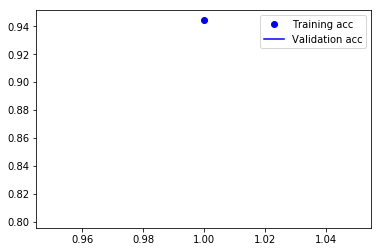

<Figure size 432x288 with 0 Axes>

In [10]:
#显示训练过程中精度变化
if is_load_model is False:
    acc=history.history['acc']
    val_acc=history.history['val_acc']
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    epochs=range(1,len(acc)+1)
    plt.plot(epochs,acc,'bo',label='Training acc')
    plt.plot(epochs,val_acc,'b',label='Validation acc')
    plt.legend()
    plt.figure()
    plt.show()
else:
    model=keras.models.load_model("/data/keras/models/01281643.h")

In [11]:
#测试集评估
test_loss,test_acc=model.evaluate_generator(test_generator,steps=test_generator.n/test_generator.batch_size)
print ("测试集 acc:%f" % (test_acc))

测试集 acc:0.810920


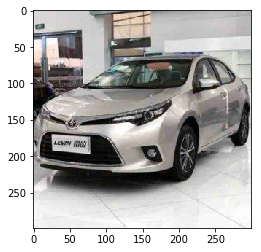

[('雷凌', 0.999997), ('卡罗拉', 2.939367e-06), ('途观', 3.2262715e-10), ('思域', 2.86753e-10), ('高尔夫', 2.7970035e-10), ('锋范', 1.3523414e-10), ('轩逸', 1.3036061e-10), ('凯美瑞', 9.003159e-11), ('帕萨特', 7.615885e-11), ('特斯拉', 4.1867704e-11), ('朗逸', 3.546549e-11), ('速腾', 2.69176e-11), ('福克斯', 2.1344239e-11), ('威驰', 1.6951222e-11), ('雅阁', 1.1988115e-11), ('飞度', 1.027626e-11), ('迈腾', 6.926632e-12), ('天籁', 2.3441336e-12), ('福睿斯', 1.7422579e-12), ('蒙迪欧', 1.1560422e-13)]


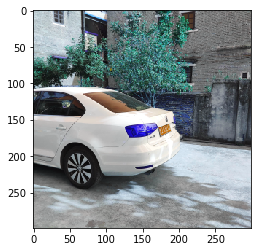

[('速腾', 0.96388775), ('帕萨特', 0.021854771), ('迈腾', 0.010846322), ('高尔夫', 0.0014977048), ('朗逸', 0.0014942551), ('特斯拉', 0.00028592593), ('雅阁', 6.281313e-05), ('思域', 3.4204004e-05), ('途观', 1.0513267e-05), ('福克斯', 6.7468163e-06), ('飞度', 5.678875e-06), ('卡罗拉', 4.3828654e-06), ('凯美瑞', 3.6383221e-06), ('蒙迪欧', 1.6512132e-06), ('威驰', 1.4535624e-06), ('锋范', 1.3901163e-06), ('轩逸', 2.6161243e-07), ('雷凌', 2.4220128e-07), ('天籁', 1.810326e-07), ('福睿斯', 6.0334905e-08)]


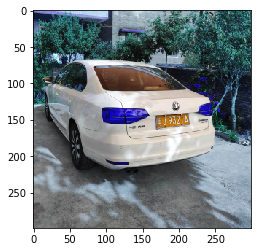

[('速腾', 0.99995244), ('卡罗拉', 2.2829587e-05), ('高尔夫', 1.1476734e-05), ('锋范', 3.7049945e-06), ('迈腾', 3.0171532e-06), ('威驰', 2.4545943e-06), ('朗逸', 2.1487797e-06), ('帕萨特', 9.0682386e-07), ('飞度', 4.6748747e-07), ('雷凌', 3.392592e-07), ('福克斯', 6.989788e-08), ('思域', 5.2983246e-08), ('轩逸', 4.299578e-08), ('蒙迪欧', 3.5818132e-08), ('特斯拉', 3.1010313e-08), ('凯美瑞', 1.1042525e-08), ('福睿斯', 2.486373e-09), ('雅阁', 2.0008772e-09), ('途观', 1.3037301e-09), ('天籁', 3.446262e-10)]


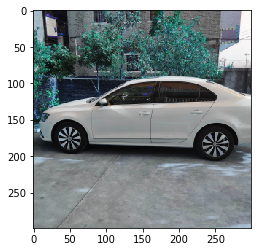

[('速腾', 0.5915191), ('帕萨特', 0.30394936), ('迈腾', 0.09257289), ('朗逸', 0.010871271), ('凯美瑞', 0.00046855755), ('天籁', 0.00015903228), ('高尔夫', 0.00010774504), ('卡罗拉', 0.00010130517), ('途观', 9.245351e-05), ('雷凌', 6.7855835e-05), ('思域', 3.763562e-05), ('特斯拉', 1.7082017e-05), ('福克斯', 1.5410871e-05), ('威驰', 8.386477e-06), ('蒙迪欧', 4.63211e-06), ('雅阁', 3.0361903e-06), ('飞度', 2.576614e-06), ('轩逸', 1.2580715e-06), ('锋范', 3.7090948e-07), ('福睿斯', 3.303724e-08)]


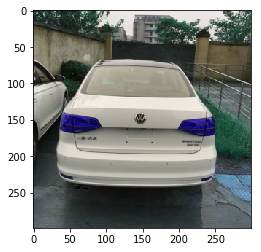

[('速腾', 0.9999423), ('朗逸', 3.1722368e-05), ('高尔夫', 1.1468028e-05), ('帕萨特', 8.127553e-06), ('福克斯', 2.2919678e-06), ('卡罗拉', 1.4673183e-06), ('威驰', 1.0836138e-06), ('迈腾', 5.459967e-07), ('思域', 4.959135e-07), ('特斯拉', 1.12417986e-07), ('飞度', 1.0627435e-07), ('凯美瑞', 5.3736137e-08), ('蒙迪欧', 4.9184806e-08), ('途观', 4.0615195e-08), ('雷凌', 3.66976e-08), ('锋范', 3.49527e-08), ('雅阁', 1.1293844e-08), ('天籁', 9.856305e-09), ('轩逸', 5.559712e-09), ('福睿斯', 3.7591905e-10)]


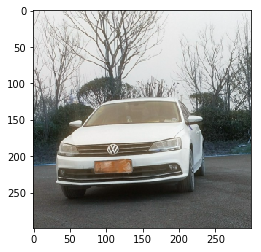

[('速腾', 0.9999994), ('朗逸', 3.780299e-07), ('迈腾', 1.1995499e-07), ('帕萨特', 8.441634e-08), ('思域', 3.109985e-08), ('高尔夫', 2.982549e-08), ('卡罗拉', 2.1200853e-08), ('途观', 1.9394198e-08), ('凯美瑞', 9.141394e-09), ('雅阁', 1.7574977e-09), ('威驰', 7.718597e-10), ('飞度', 6.277976e-10), ('轩逸', 5.886094e-10), ('蒙迪欧', 5.255269e-10), ('天籁', 2.766418e-10), ('福克斯', 2.4755434e-10), ('特斯拉', 6.159001e-11), ('锋范', 3.5622928e-11), ('福睿斯', 2.2550344e-11), ('雷凌', 1.7809077e-11)]


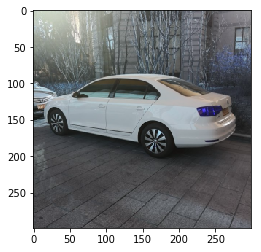

[('速腾', 0.97269034), ('帕萨特', 0.02637692), ('迈腾', 0.00091913855), ('朗逸', 7.044498e-06), ('特斯拉', 5.002739e-06), ('高尔夫', 6.3050334e-07), ('蒙迪欧', 5.296677e-07), ('雅阁', 1.6545867e-07), ('思域', 7.391461e-08), ('轩逸', 5.939523e-08), ('天籁', 4.8229712e-08), ('卡罗拉', 1.8482934e-08), ('凯美瑞', 1.5102117e-08), ('途观', 8.743618e-09), ('福睿斯', 4.020513e-09), ('锋范', 3.878692e-09), ('福克斯', 1.6962955e-09), ('雷凌', 1.0904833e-09), ('威驰', 4.2822695e-10), ('飞度', 1.4989492e-10)]


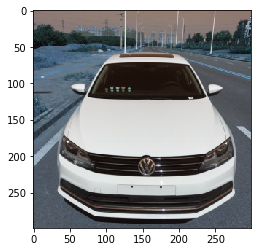

[('速腾', 0.5559367), ('迈腾', 0.40050352), ('朗逸', 0.03696149), ('帕萨特', 0.0049645663), ('雅阁', 0.00037889736), ('思域', 0.00030740633), ('高尔夫', 0.00023650988), ('天籁', 0.00020516397), ('卡罗拉', 0.00016500158), ('特斯拉', 6.8178735e-05), ('蒙迪欧', 6.0622886e-05), ('凯美瑞', 6.0576298e-05), ('轩逸', 5.5232937e-05), ('途观', 4.4031e-05), ('福睿斯', 1.9735311e-05), ('福克斯', 1.1314611e-05), ('雷凌', 6.0520033e-06), ('锋范', 5.2835003e-06), ('飞度', 5.1790907e-06), ('威驰', 4.4992685e-06)]


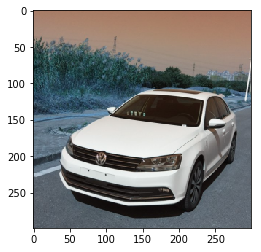

[('速腾', 0.9999368), ('迈腾', 4.853437e-05), ('帕萨特', 4.705142e-06), ('高尔夫', 4.5108923e-06), ('朗逸', 3.4402815e-06), ('思域', 1.0140525e-06), ('雅阁', 1.7959329e-07), ('特斯拉', 1.7612014e-07), ('卡罗拉', 1.6956184e-07), ('凯美瑞', 1.688135e-07), ('天籁', 8.369142e-08), ('飞度', 5.3123074e-08), ('蒙迪欧', 4.7300215e-08), ('轩逸', 3.0535293e-08), ('途观', 3.0315356e-08), ('威驰', 2.6912941e-08), ('福克斯', 1.8104025e-08), ('雷凌', 1.7821886e-08), ('锋范', 9.564055e-09), ('福睿斯', 8.607342e-09)]


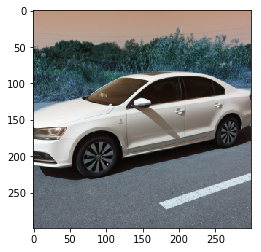

[('速腾', 0.99926156), ('帕萨特', 0.00065195025), ('迈腾', 5.8003545e-05), ('朗逸', 1.3793732e-05), ('卡罗拉', 7.070471e-06), ('高尔夫', 3.5928447e-06), ('特斯拉', 2.0982134e-06), ('思域', 8.6032117e-07), ('途观', 3.895804e-07), ('天籁', 3.4182526e-07), ('凯美瑞', 1.574397e-07), ('威驰', 8.098213e-08), ('蒙迪欧', 2.2740728e-08), ('轩逸', 2.147979e-08), ('雷凌', 1.9592518e-08), ('福克斯', 1.920327e-08), ('锋范', 7.94147e-09), ('飞度', 4.386708e-09), ('雅阁', 1.7215235e-09), ('福睿斯', 1.6446007e-10)]


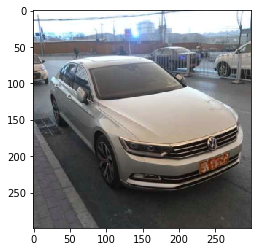

[('迈腾', 0.99914217), ('帕萨特', 0.00085431046), ('雅阁', 2.4302906e-06), ('朗逸', 5.386888e-07), ('速腾', 2.6222668e-07), ('天籁', 1.13888326e-07), ('特斯拉', 9.116576e-08), ('凯美瑞', 7.874285e-08), ('途观', 5.8799326e-08), ('蒙迪欧', 3.44325e-08), ('思域', 2.1495953e-08), ('高尔夫', 4.250903e-09), ('卡罗拉', 3.231789e-09), ('轩逸', 7.7338247e-10), ('福克斯', 1.409294e-10), ('福睿斯', 1.2661971e-10), ('锋范', 7.3922576e-11), ('雷凌', 2.666245e-11), ('飞度', 1.8553808e-11), ('威驰', 5.7709454e-12)]


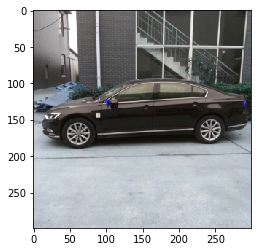

[('迈腾', 0.6222845), ('帕萨特', 0.34643522), ('天籁', 0.03048951), ('雅阁', 0.0006029153), ('特斯拉', 7.6688135e-05), ('途观', 5.3519787e-05), ('凯美瑞', 3.849177e-05), ('轩逸', 5.6378785e-06), ('思域', 4.8747725e-06), ('朗逸', 3.5655928e-06), ('速腾', 2.930776e-06), ('高尔夫', 9.98868e-07), ('蒙迪欧', 5.032079e-07), ('雷凌', 3.743577e-07), ('福克斯', 2.3078691e-07), ('卡罗拉', 7.365454e-08), ('锋范', 3.3684655e-09), ('飞度', 3.0965774e-09), ('威驰', 4.5503046e-10), ('福睿斯', 1.4312163e-10)]


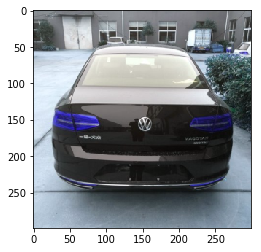

[('迈腾', 0.9995845), ('速腾', 0.0002695552), ('帕萨特', 7.315864e-05), ('朗逸', 6.9491754e-05), ('途观', 1.372401e-06), ('高尔夫', 1.276956e-06), ('卡罗拉', 5.527878e-07), ('思域', 3.210729e-08), ('凯美瑞', 2.6883557e-08), ('特斯拉', 1.7615339e-08), ('蒙迪欧', 1.6802838e-08), ('雅阁', 1.4641336e-08), ('轩逸', 1.2591035e-08), ('威驰', 3.037682e-09), ('飞度', 1.3662768e-09), ('天籁', 1.3301314e-09), ('福睿斯', 1.9506528e-10), ('雷凌', 1.8070309e-10), ('锋范', 8.558895e-11), ('福克斯', 1.9737509e-11)]


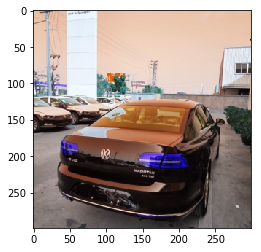

[('迈腾', 0.99977833), ('帕萨特', 0.00014901), ('特斯拉', 3.152423e-05), ('速腾', 3.112462e-05), ('雅阁', 7.919859e-06), ('朗逸', 7.0938233e-07), ('高尔夫', 6.24022e-07), ('思域', 3.396987e-07), ('凯美瑞', 3.3871396e-07), ('途观', 5.5085316e-08), ('蒙迪欧', 4.8364672e-08), ('卡罗拉', 4.83205e-08), ('天籁', 2.5376037e-08), ('雷凌', 2.5660023e-09), ('飞度', 1.2506913e-09), ('锋范', 3.3885944e-10), ('轩逸', 1.9544466e-10), ('福克斯', 1.6932854e-10), ('威驰', 9.813114e-11), ('福睿斯', 8.608229e-12)]


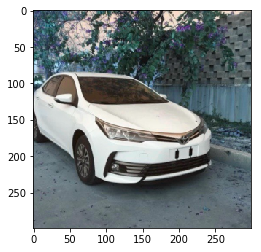

[('卡罗拉', 0.86596507), ('雷凌', 0.12471637), ('思域', 0.002370097), ('帕萨特', 0.0022531974), ('特斯拉', 0.0018254721), ('轩逸', 0.0009947402), ('朗逸', 0.00047966896), ('雅阁', 0.00035257568), ('锋范', 0.00021116155), ('福克斯', 0.00015317825), ('迈腾', 0.00012620773), ('福睿斯', 0.00012334446), ('凯美瑞', 9.6349955e-05), ('速腾', 8.857089e-05), ('高尔夫', 7.5451324e-05), ('天籁', 5.728812e-05), ('途观', 4.700794e-05), ('飞度', 2.8878123e-05), ('威驰', 2.6194342e-05), ('蒙迪欧', 9.184745e-06)]


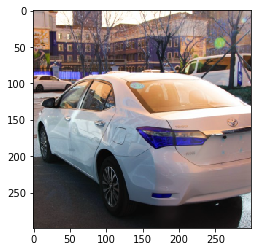

[('卡罗拉', 0.99445784), ('雷凌', 0.005038129), ('思域', 0.00015915747), ('威驰', 9.0605485e-05), ('朗逸', 5.659002e-05), ('速腾', 5.4129843e-05), ('帕萨特', 4.0113257e-05), ('雅阁', 3.9174654e-05), ('特斯拉', 2.3655339e-05), ('锋范', 1.8555711e-05), ('凯美瑞', 1.2719749e-05), ('福睿斯', 3.4561904e-06), ('迈腾', 2.0588905e-06), ('轩逸', 1.4384727e-06), ('蒙迪欧', 1.0474026e-06), ('福克斯', 6.9655454e-07), ('高尔夫', 4.4888867e-07), ('飞度', 7.1702345e-08), ('天籁', 4.499196e-08), ('途观', 3.702724e-08)]


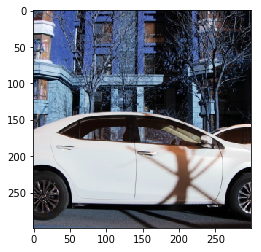

[('卡罗拉', 0.9917237), ('雷凌', 0.008151113), ('锋范', 5.747691e-05), ('思域', 3.087796e-05), ('轩逸', 9.727046e-06), ('飞度', 9.367104e-06), ('雅阁', 6.331164e-06), ('高尔夫', 3.470489e-06), ('福克斯', 3.291143e-06), ('福睿斯', 2.1152266e-06), ('途观', 5.5388557e-07), ('凯美瑞', 4.242647e-07), ('帕萨特', 3.6918027e-07), ('威驰', 3.6033916e-07), ('蒙迪欧', 2.4228342e-07), ('速腾', 1.8107157e-07), ('朗逸', 1.412064e-07), ('特斯拉', 7.532014e-08), ('天籁', 6.221908e-08), ('迈腾', 3.6090018e-08)]


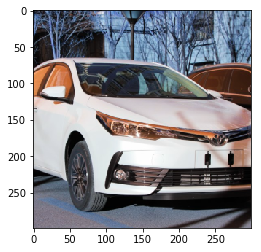

[('卡罗拉', 0.9980292), ('雷凌', 0.0019517395), ('轩逸', 1.2193166e-05), ('凯美瑞', 4.9648393e-06), ('思域', 5.459014e-07), ('帕萨特', 3.7301868e-07), ('朗逸', 2.5071847e-07), ('天籁', 2.3401691e-07), ('速腾', 1.2438304e-07), ('雅阁', 9.742855e-08), ('迈腾', 5.0365593e-08), ('特斯拉', 4.5479656e-08), ('威驰', 4.533978e-08), ('途观', 4.053455e-08), ('高尔夫', 2.363399e-08), ('福克斯', 2.1423206e-08), ('福睿斯', 8.651169e-09), ('蒙迪欧', 7.315564e-09), ('飞度', 3.2006306e-09), ('锋范', 2.4969553e-09)]


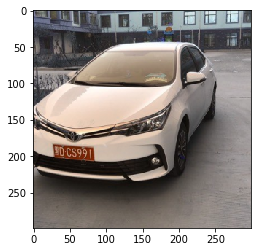

[('卡罗拉', 0.99984324), ('雷凌', 0.00014695033), ('思域', 3.1989027e-06), ('威驰', 2.9467367e-06), ('迈腾', 7.085954e-07), ('凯美瑞', 5.2569624e-07), ('轩逸', 5.2111403e-07), ('特斯拉', 4.3974956e-07), ('帕萨特', 4.1948869e-07), ('高尔夫', 3.118071e-07), ('速腾', 2.1718438e-07), ('朗逸', 1.9220947e-07), ('途观', 1.571994e-07), ('飞度', 5.0408467e-08), ('天籁', 4.231852e-08), ('锋范', 2.3170996e-08), ('福克斯', 7.3179938e-09), ('雅阁', 6.990955e-09), ('蒙迪欧', 2.4824482e-09), ('福睿斯', 2.0294144e-09)]


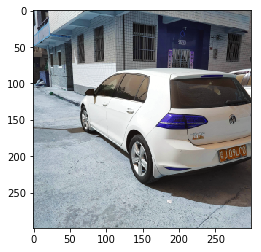

[('高尔夫', 0.99999106), ('飞度', 5.8039273e-06), ('锋范', 1.5168835e-06), ('迈腾', 1.1083572e-06), ('帕萨特', 1.0076037e-07), ('威驰', 7.843978e-08), ('福克斯', 7.5462864e-08), ('速腾', 5.661121e-08), ('卡罗拉', 4.9168257e-08), ('途观', 3.5451603e-08), ('朗逸', 3.0576118e-08), ('特斯拉', 1.9356195e-08), ('雅阁', 9.179705e-09), ('思域', 8.421602e-09), ('雷凌', 5.4012785e-09), ('蒙迪欧', 1.4810023e-09), ('凯美瑞', 8.9525787e-10), ('轩逸', 2.2778152e-10), ('天籁', 1.8581803e-10), ('福睿斯', 2.96862e-11)]


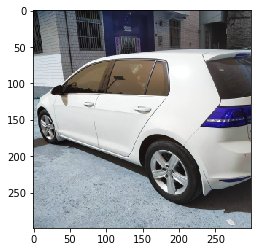

[('高尔夫', 0.8767072), ('锋范', 0.11644209), ('飞度', 0.0067969714), ('迈腾', 2.233818e-05), ('威驰', 2.1919934e-05), ('雅阁', 4.691822e-06), ('帕萨特', 2.508685e-06), ('凯美瑞', 5.0823934e-07), ('福克斯', 3.674849e-07), ('特斯拉', 2.9563012e-07), ('雷凌', 2.950094e-07), ('途观', 2.0999292e-07), ('朗逸', 1.9629798e-07), ('速腾', 1.4321473e-07), ('天籁', 1.2677019e-07), ('卡罗拉', 4.6067242e-08), ('轩逸', 1.5925972e-08), ('蒙迪欧', 6.258054e-09), ('思域', 5.522681e-09), ('福睿斯', 8.931199e-11)]


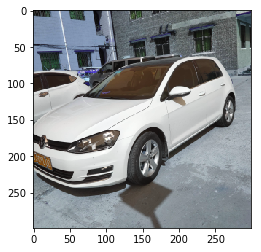

[('高尔夫', 0.99999833), ('飞度', 1.5843793e-06), ('福克斯', 3.8219078e-08), ('威驰', 3.1631952e-08), ('锋范', 3.027648e-08), ('迈腾', 1.4663443e-08), ('雷凌', 1.2131637e-08), ('卡罗拉', 9.826204e-09), ('帕萨特', 4.7228093e-09), ('途观', 4.6508397e-09), ('特斯拉', 3.589951e-09), ('思域', 2.7573765e-09), ('速腾', 1.396177e-09), ('雅阁', 3.860632e-10), ('朗逸', 1.6464036e-10), ('凯美瑞', 7.1927686e-11), ('天籁', 4.3771545e-11), ('轩逸', 2.215494e-11), ('蒙迪欧', 4.7532755e-12), ('福睿斯', 3.459437e-12)]


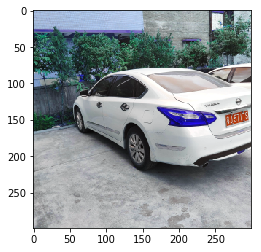

[('天籁', 0.97814274), ('迈腾', 0.0077256677), ('轩逸', 0.005425874), ('帕萨特', 0.0022847725), ('蒙迪欧', 0.0021484403), ('特斯拉', 0.0013536784), ('朗逸', 0.0012454737), ('福克斯', 0.0009222938), ('雅阁', 0.0005205229), ('凯美瑞', 0.0001353362), ('卡罗拉', 2.6312546e-05), ('途观', 2.4047991e-05), ('高尔夫', 1.33663925e-05), ('思域', 1.26389195e-05), ('雷凌', 7.5346024e-06), ('速腾', 4.4630783e-06), ('福睿斯', 3.5229743e-06), ('威驰', 2.1995304e-06), ('锋范', 8.2457774e-07), ('飞度', 2.8926252e-07)]


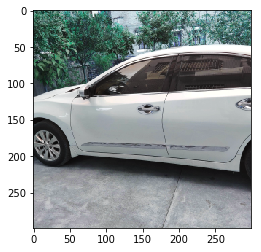

[('福克斯', 0.49761567), ('天籁', 0.49270234), ('蒙迪欧', 0.0072758533), ('轩逸', 0.0011262288), ('迈腾', 0.00059946446), ('威驰', 0.00021860171), ('卡罗拉', 0.00016903793), ('朗逸', 0.00015946387), ('帕萨特', 4.843688e-05), ('思域', 2.5817337e-05), ('飞度', 1.2124599e-05), ('凯美瑞', 1.0421253e-05), ('速腾', 7.930658e-06), ('高尔夫', 7.922471e-06), ('雅阁', 7.2606795e-06), ('途观', 5.4166317e-06), ('雷凌', 3.7070024e-06), ('福睿斯', 3.0622537e-06), ('特斯拉', 8.341078e-07), ('锋范', 3.6720263e-07)]


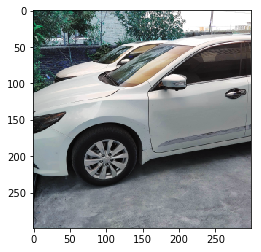

[('天籁', 0.9374506), ('轩逸', 0.05827671), ('迈腾', 0.0019852407), ('朗逸', 0.0012361085), ('蒙迪欧', 0.00066545885), ('福克斯', 0.000135503), ('威驰', 8.976894e-05), ('福睿斯', 7.273643e-05), ('帕萨特', 2.51657e-05), ('雅阁', 1.8328563e-05), ('速腾', 1.5974112e-05), ('高尔夫', 1.0528331e-05), ('卡罗拉', 4.2772813e-06), ('特斯拉', 4.2593215e-06), ('凯美瑞', 3.6317992e-06), ('锋范', 3.173541e-06), ('思域', 1.4608114e-06), ('飞度', 6.6476645e-07), ('途观', 3.7346962e-07), ('雷凌', 1.13432854e-07)]


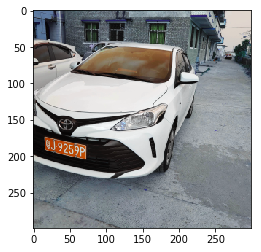

[('威驰', 0.983244), ('福克斯', 0.0070462506), ('思域', 0.0058836946), ('雷凌', 0.0019316553), ('卡罗拉', 0.0011573733), ('轩逸', 0.00031104326), ('飞度', 0.0001099179), ('特斯拉', 8.499696e-05), ('速腾', 5.528711e-05), ('高尔夫', 4.1427684e-05), ('锋范', 3.8448645e-05), ('福睿斯', 2.4884588e-05), ('凯美瑞', 2.4467032e-05), ('朗逸', 1.3285873e-05), ('雅阁', 1.0119735e-05), ('途观', 7.1179634e-06), ('帕萨特', 5.806001e-06), ('蒙迪欧', 5.7015377e-06), ('迈腾', 3.2316434e-06), ('天籁', 1.3272962e-06)]


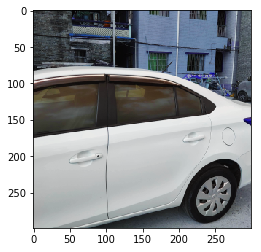

[('威驰', 0.9987921), ('锋范', 0.00078326993), ('飞度', 0.00021324413), ('福克斯', 0.00010874734), ('卡罗拉', 8.471327e-05), ('高尔夫', 3.5908001e-06), ('途观', 2.8626991e-06), ('福睿斯', 2.6388923e-06), ('天籁', 2.0712469e-06), ('特斯拉', 1.5806552e-06), ('轩逸', 1.4847168e-06), ('雷凌', 1.100075e-06), ('凯美瑞', 1.0362729e-06), ('迈腾', 6.166596e-07), ('蒙迪欧', 2.4461957e-07), ('朗逸', 2.386464e-07), ('速腾', 1.8320216e-07), ('雅阁', 1.8085912e-07), ('思域', 1.788426e-07), ('帕萨特', 5.1079915e-08)]


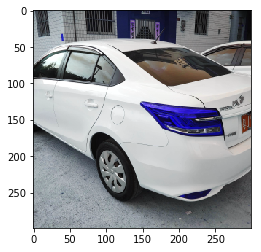

[('威驰', 0.9999523), ('凯美瑞', 2.2205048e-05), ('卡罗拉', 2.1960735e-05), ('锋范', 2.3424784e-06), ('朗逸', 4.941556e-07), ('思域', 2.96381e-07), ('轩逸', 9.261235e-08), ('速腾', 8.125449e-08), ('雷凌', 4.6201347e-08), ('天籁', 4.2213408e-08), ('雅阁', 3.680002e-08), ('帕萨特', 1.0013758e-08), ('特斯拉', 4.6686766e-09), ('福克斯', 3.418714e-09), ('迈腾', 2.4680733e-09), ('飞度', 1.1410421e-09), ('蒙迪欧', 4.88199e-10), ('途观', 3.729753e-10), ('福睿斯', 2.0631742e-10), ('高尔夫', 1.4227196e-10)]


In [12]:
#显示真实收集的图片的结果
from keras.preprocessing import image
import numpy as np
import cv2
from mytool import MyTool
test_imgs=['/data/keras/download/qiche/timg2.jpg',
          '/data/keras/download/qiche/su1.jpg',
          '/data/keras/download/qiche/su2.jpg',
          '/data/keras/download/qiche/su3.jpg',
          '/data/test/su21.jpg',
          '/data/test/su22.jpg',
          '/data/test/su23.jpg',
          '/data/test/su24.jpeg',
          '/data/test/su25.jpeg',
          '/data/test/su26.jpeg',
           '/data/test/mt20.jpg',
           '/data/test/mt21.jpg',
           '/data/test/mt22.jpg',
           '/data/test/mt23.jpg',
           '/data/test/kll20.jpg',
            '/data/test/kll21.jpg',
            '/data/test/kll22.jpg',
            '/data/test/kll23.jpg',
            '/data/test/kll24.jpg',
           '/data/test/g20.jpg',
           '/data/test/g21.jpg',
           '/data/test/g22.jpg',
           '/data/test/t20.jpg',
           '/data/test/t21.jpg',
           '/data/test/t22.jpg',
           '/data/test/w20.jpg',
           '/data/test/w21.jpg',
           '/data/test/w22.jpg',
          ]

for img_path in test_imgs:
    #img = image.load_img(img_path, target_size=(img_height, img_width))
    img =cv2.imread(img_path)
#     plt.imshow(img)
#     plt.show()
    img=MyTool.cro_img(img,img_height,img_width)
    plt.imshow(img)
    plt.show()
    
    x = image.img_to_array(img)
    x=x/255
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x)
    paixu=dict(zip(train_generator.class_indices,preds[0]))
    paixu= sorted(paixu.items(), key=lambda x: x[1], reverse=True)
    print(paixu)

In [8]:
#contv_base=VGG16(weights='imagenet',include_top=False,input_shape=(img_height,img_width,3))
# contv_base.summary()
# contv_base.trainable=True
# set_trainable=False
# for layer in contv_base.layers:
#     if layer.name=='block1_conv5':
#         set_trainable=True
#     if set_trainable:
#         layer.trainable=True
#     else:
#         layer.trainable=False


#contv_base=keras.applications.inception_resnet_v2.InceptionResNetV2(input_shape=(img_height,img_width,3))
       

# contv_base=xception.Xception(weights='imagenet',include_top=False,input_shape=(img_height,img_width,3))
# contv_base.summary()
# for layer in contv_base.layers:
#      layer.trainable = False
# for i, layer in enumerate(contv_base.layers):
#     print(i, layer.name)


# model=models.Sequential()
# model.add(contv_base)
# model.add(layers.Flatten())
# #model.add(layers.Dropout(0.1))
# model.add(layers.Dense(256,activation='relu'))
# model.add(layers.Dense(mod_num,activation='softmax'))
# model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])